# LSTM Stock Predictor Using Closing Prices

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin closing prices to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [55]:
import numpy as np
import pandas as pd
import hvplot.pandas

In [56]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [57]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [58]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [59]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [60]:
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [61]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [62]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)
print(f"X sample values: \n{X[:5]} \n")
print(f"y sample values: \n{y[:5]}")

X sample values: 
[[9114.719727 8870.820313 9251.269531 8218.049805 6937.080078 7701.25
  7592.720215 8260.69043  8696.830078 8569.290039]
 [8870.820313 9251.269531 8218.049805 6937.080078 7701.25     7592.720215
  8260.69043  8696.830078 8569.290039 8084.609863]
 [9251.269531 8218.049805 6937.080078 7701.25     7592.720215 8260.69043
  8696.830078 8569.290039 8084.609863 8911.269531]
 [8218.049805 6937.080078 7701.25     7592.720215 8260.69043  8696.830078
  8569.290039 8084.609863 8911.269531 8544.69043 ]
 [6937.080078 7701.25     7592.720215 8260.69043  8696.830078 8569.290039
  8084.609863 8911.269531 8544.69043  9485.639648]] 

y sample values: 
[[ 8084.609863]
 [ 8911.269531]
 [ 8544.69043 ]
 [ 9485.639648]
 [10033.75    ]]


In [63]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

In [64]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.

X_train_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
X_test_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

X_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)
X_train = X_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

y_test_scaler.fit(y_test)
X_test_scaler.fit(X_test)
y_test = y_test_scaler.transform(y_test)
X_test = X_test_scaler.transform(X_test)

In [65]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print(f"X_train sample values: \n{X_train[:5]} \n")
print(f"X_test sample values: \n{X_test[:5]}")

X_train sample values: 
[[[0.7111066 ]
  [0.68162134]
  [0.72761425]
  [0.60270722]
  [0.44784942]
  [0.54023074]
  [0.52711046]
  [0.60786209]
  [0.66058747]
  [0.64516902]]

 [[0.68162134]
  [0.72761425]
  [0.60270722]
  [0.44784942]
  [0.54023074]
  [0.52711046]
  [0.60786209]
  [0.66058747]
  [0.64516902]
  [0.58657552]]

 [[0.72761425]
  [0.60270722]
  [0.44784942]
  [0.54023074]
  [0.52711046]
  [0.60786209]
  [0.66058747]
  [0.64516902]
  [0.58657552]
  [0.68651129]]

 [[0.60270722]
  [0.44784942]
  [0.54023074]
  [0.52711046]
  [0.60786209]
  [0.66058747]
  [0.64516902]
  [0.58657552]
  [0.68651129]
  [0.64219515]]

 [[0.44784942]
  [0.54023074]
  [0.52711046]
  [0.60786209]
  [0.66058747]
  [0.64516902]
  [0.58657552]
  [0.68651129]
  [0.64219515]
  [0.7559475 ]]] 

X_test sample values: 
[[[0.01034043]
  [0.00242586]
  [0.00307681]
  [0.00183924]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.01974407]]

 [[0.00242586]
  [0.00307681]
  [0.0018

---

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [67]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output Layer
model.add(Dense(1))

In [68]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [69]:
# Summarize the model
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 10, 30)            3840      
_________________________________________________________________
dropout_12 (Dropout)         (None, 10, 30)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 10, 30)            7320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 10, 30)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_14 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [70]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
371/371 [==============================] - 1s 4ms/step - loss: 0.0276
Epoch 2/10
371/371 [==============================] - 1s 4ms/step - loss: 0.0241
Epoch 3/10
371/371 [==============================] - 1s 4ms/step - loss: 0.0290
Epoch 4/10
371/371 [==============================] - 1s 4ms/step - loss: 0.0282
Epoch 5/10
371/371 [==============================] - 1s 4ms/step - loss: 0.0246
Epoch 6/10
371/371 [==============================] - 2s 4ms/step - loss: 0.0230
Epoch 7/10
371/371 [==============================] - 1s 4ms/step - loss: 0.0226
Epoch 8/10
371/371 [==============================] - 2s 5ms/step - loss: 0.0198
Epoch 9/10
371/371 [==============================] - 2s 5ms/step - loss: 0.0199
Epoch 10/10
371/371 [==============================] - 2s 5ms/step - loss: 0.0184


---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [71]:
# Evaluate the model
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.0487


0.04872175678610802

In [72]:
# Make some predictions
predicted = model.predict(X_test)

In [73]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [74]:
pd.DataFrame(y_test).head()

,0
0,0.021015
1,0.026440
2,0.022409
3,0.027472
4,0.045503


In [75]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2019-02-20,3924.239990,4248.814941
2019-02-21,3974.050049,4270.220703
2019-02-22,3937.040039,4296.877441
2019-02-23,3983.530029,4322.457520
2019-02-24,4149.089844,4345.416504


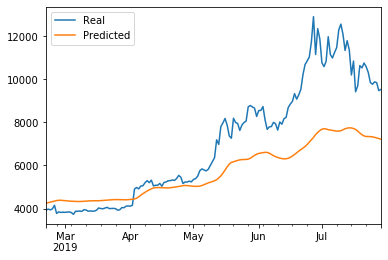

In [76]:
# Plot the real vs predicted values as a line chart
stocks.plot()

# Which model has a lower loss?

The model with closing prices has a lower loss at loss: 0.0487 compared to the model with fear and greed wich has a loss of loss: 0.1911.

#  Which model tracks the actual values better over time?

At this time both models tracks the actual values similarly, when we look at the DataFrame of Real and Predicted values. However, looking at the predicted values the model with fear and greed has predicted values that are more closer to the Real values.

#  Which window size works best for the model?

The 10 day window size works best for the model with 20 units and 2 batch sizes. This window provides the lowest loss at loss: 0.0283 and predicted values that are closer 
to the real values.

### Hints and Considerations

Experiment with the model architecture and parameters to see which provides the best results, but be sure to use the same architecture and parameters when comparing each model.

For training, use at least 10 estimators for both models.


In [ ]:
# Experimenting with the model architecture and parameters

For this experiment we will increase the number of units from 30 to 40 and increase the batch size from 1 to 2 and see what is the impact on the models

In [25]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

number_units = 40
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output Layer
model.add(Dense(1))

In [26]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [27]:
# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 40)            6720      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 40)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 40)            12960     
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 40)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_5 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [28]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=2, verbose=1)

Epoch 1/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0446
Epoch 2/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0327
Epoch 3/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0353
Epoch 4/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0258
Epoch 5/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0230
Epoch 6/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0201
Epoch 7/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0168
Epoch 8/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0176
Epoch 9/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0156
Epoch 10/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0148


# Model Performance

In [29]:
# Evaluate the model
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.0354


0.03538717329502106

In [30]:
# Make some predictions
predicted = model.predict(X_test)

In [31]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [32]:
pd.DataFrame(y_test).head()

,0
0,0.021015
1,0.026440
2,0.022409
3,0.027472
4,0.045503


In [33]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2019-02-20,3924.239990,3755.824219
2019-02-21,3974.050049,3782.093506
2019-02-22,3937.040039,3819.560547
2019-02-23,3983.530029,3858.318848
2019-02-24,4149.089844,3896.458740


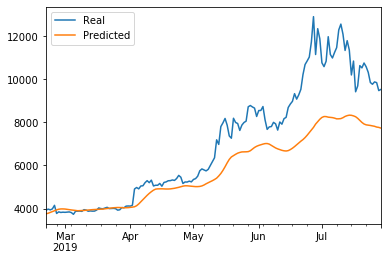

In [34]:
# Plot the real vs predicted values as a line chart
stocks.plot()

In [35]:
# Experimenting with the model architecture and parameters

Now we will experiment using 20 number of units instead of 40 and stil 2 batch sizes to see what will the impact be on the models

In [36]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

number_units = 20
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output Layer
model.add(Dense(1))

In [37]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [38]:
# Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10, 20)            1760      
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 20)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 10, 20)            3280      
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 20)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_8 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [39]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=2, verbose=1)

Epoch 1/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0451
Epoch 2/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0315
Epoch 3/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0286
Epoch 4/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0233
Epoch 5/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0200
Epoch 6/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0184
Epoch 7/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0193
Epoch 8/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0174
Epoch 9/10
186/186 [==============================] - 1s 6ms/step - loss: 0.0164
Epoch 10/10
186/186 [==============================] - 1s 6ms/step - loss: 0.0152


# Model Performance

In [40]:
# Evaluate the model
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.0283


0.028289979323744774

In [41]:
# Make some predictions
predicted = model.predict(X_test)

In [42]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [43]:
pd.DataFrame(y_test).head()

,0
0,0.021015
1,0.026440
2,0.022409
3,0.027472
4,0.045503


In [44]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2019-02-20,3924.239990,3880.136719
2019-02-21,3974.050049,3893.032227
2019-02-22,3937.040039,3918.277344
2019-02-23,3983.530029,3947.366943
2019-02-24,4149.089844,3979.828125


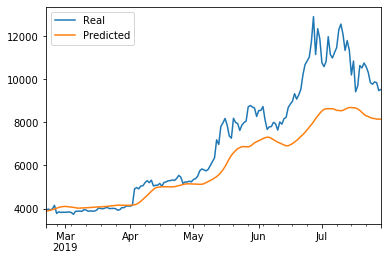

In [45]:
# Plot the real vs predicted values as a line chart
stocks.plot()

Now, let's experiment with 25 units and 15 epochs with 1 batch size

In [46]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

number_units = 25
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output Layer
model.add(Dense(1))

In [47]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [48]:
# Summarize the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 10, 25)            2700      
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 25)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 10, 25)            5100      
_________________________________________________________________
dropout_10 (Dropout)         (None, 10, 25)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 25)                5100      
_________________________________________________________________
dropout_11 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [49]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=15, shuffle=False, batch_size=1, verbose=1)

Epoch 1/15
371/371 [==============================] - 2s 4ms/step - loss: 0.0375
Epoch 2/15
371/371 [==============================] - 1s 4ms/step - loss: 0.0245
Epoch 3/15
371/371 [==============================] - 1s 4ms/step - loss: 0.0288
Epoch 4/15
371/371 [==============================] - 1s 4ms/step - loss: 0.0293
Epoch 5/15
371/371 [==============================] - 2s 4ms/step - loss: 0.0248
Epoch 6/15
371/371 [==============================] - 1s 4ms/step - loss: 0.0223
Epoch 7/15
371/371 [==============================] - 2s 4ms/step - loss: 0.0214
Epoch 8/15
371/371 [==============================] - 1s 4ms/step - loss: 0.0193
Epoch 9/15
371/371 [==============================] - 2s 4ms/step - loss: 0.0181
Epoch 10/15
371/371 [==============================] - 2s 4ms/step - loss: 0.0173
Epoch 11/15
371/371 [==============================] - 2s 4ms/step - loss: 0.0171
Epoch 12/15
371/371 [==============================] - 2s 4ms/step - loss: 0.0154
Epoch 13/15
371/371 [====

# Model Performance

In [50]:
# Evaluate the model
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.0284


0.028416316956281662

In [51]:
# Make somme predictions
predicted = model.predict(X_test)

In [52]:
# Recover the original prices instead of the predicted prices
predicted = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test).reshape(-1, 1)

In [53]:
# Create a DataFrame of Real and Predicted Values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ])
stocks.head()

,Real,Predicted
2019-02-20,3924.239990,3880.136719
2019-02-21,3974.050049,3893.032227
2019-02-22,3937.040039,3918.277344
2019-02-23,3983.530029,3947.366943
2019-02-24,4149.089844,3979.828125


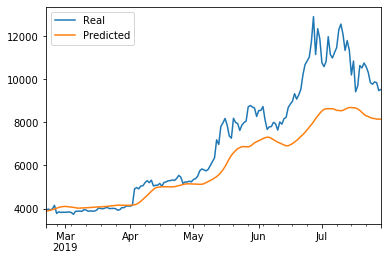

In [54]:
# Plot the real vs predicted values as a line chart
stocks.plot()

# Which model has a lower loss?
After experimenting with the model architecture and parameters, the model with closing prices has consistently had a lower loss at each iteration with predicted values that are closer to the real values than the model with fear and greed values which has a higher loss and higher predicted values that far apart from the real values at each iteration.

# Which model tracks the actual values better over time?
Both models tracks the actual values similarly, however the model with closing prices has predicted values that are closer to the real values than the model with fear and greed values.

# Which window size works best for the model?

The 10 day window size works best for the model with 20 units and 2 batch sizes. This window provides the lowest loss at loss: 0.0283 and predicted values that are closer 
to the real values.